# Splitting DF up based on year (<2019) and previous EDA/Modeling #

### Note ###

This work builds on work in other notebooks, notably Dillon's EDA_Tues notebook, Rashid's Notebook 4, and Seth's day 2 workbook

Once I get up to train_test_split, I only use new_df, but I keep the two halves of data consistent for future testing.

## Importing libraries and datasets ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score 
from sklearn.feature_selection import RFE
pd.set_option("display.max_columns", None)
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings

In [2]:
df_ppl = pd.read_csv('data/People.csv')
df_cars = pd.read_csv('data/Vehicles.csv')
df_crashes = pd.read_csv('data/Crashes.csv')
warnings.filterwarnings('ignore')

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# making column names lowercase for ease of work
df_crashes.columns = df_crashes.columns.str.strip().str.lower()
df_cars.columns = df_cars.columns.str.strip().str.lower()
df_ppl.columns = df_ppl.columns.str.strip().str.lower()

In [4]:
# converting crash_date to datetime for future dataset split
df_crashes['crash_date'] = pd.to_datetime(df_crashes['crash_date'])

In [5]:
# creating our injury column, the future y-target
df_crashes['injury'] = df_crashes['injuries_total'] >= 1
df_crashes['injury']= df_crashes['injury'].astype(int)

In [6]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_record_id                541142 non-null  object        
 1   rd_no                          536550 non-null  object        
 2   crash_date_est_i               41029 non-null   object        
 3   crash_date                     541142 non-null  datetime64[ns]
 4   posted_speed_limit             541142 non-null  int64         
 5   traffic_control_device         541142 non-null  object        
 6   device_condition               541142 non-null  object        
 7   weather_condition              541142 non-null  object        
 8   lighting_condition             541142 non-null  object        
 9   first_crash_type               541142 non-null  object        
 10  trafficway_type                541142 non-null  object        
 11  

In [7]:
# ensuring that we only have the drivers from df_ppl
ppl_in_ppl_df = df_ppl[(df_ppl.person_type == 'DRIVER')]

### merging the three dataframes ###

In [8]:
m1 = pd.merge(df_cars, ppl_in_ppl_df, how='left', on=['crash_record_id'])

In [9]:
m2 = pd.merge(m1, df_crashes, how='left', on=['crash_record_id'])

In [10]:
full_df = m2.drop_duplicates(subset=['crash_record_id'], keep='first')

In [11]:
full_df.head()

,crash_unit_id,crash_record_id,rd_no_x,crash_date_x,unit_no,unit_type,num_passengers,vehicle_id_x,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,rd_no_y,vehicle_id_y,crash_date_y,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result value,cell_phone_use,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,not_right_of_way_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,injury
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O829999,DRIVER,JD124535,796949.0,01/22/2020 06:25:00 AM,NaN,ACAMPO,CA,95220,M,35.0,CA,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JD124535,NaN,2020-01-22 06:25:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,OTHER NONCOLLISION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",01/22/2020 12:30:00 PM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1525,S,CALIFORNIA BLVD,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4,1,41.860250,-87.695575,POINT (-87.695575177986 41.860250253825),0
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JC451435,Y,2019-09-28 03:30:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,WET,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,500",09/28/2019 06:13:00 

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541133 entries, 0 to 1960927
Columns: 150 entries, crash_unit_id to injury
dtypes: datetime64[ns](1), float64(25), int32(1), int64(7), object(116)
memory usage: 621.3+ MB


In [13]:
# picking our columns
columns = ['crash_date', 'crash_record_id', 'crash_date_x', 'latitude', 'longitude', 'injury', 'crash_month', 'crash_hour', 
           'street_name', 'damage', 'hit_and_run_i', 'roadway_surface_cond', 'road_defect',
          'weather_condition', 'crash_day_of_week', 'driver_action', 'exceed_speed_limit_i',
          'prim_contributory_cause']

In [14]:
full_df = full_df[columns]

In [15]:
# creating 1 and 0 variables for whether the accident occured during rush_hour
# rush_hour in Chicago is defined as: Monday-Friday, 7-9am and 3-7pm
# per the website the data was pulled from, Sunday = 1, so we need the days between 2-6
def rush_hour(time):
    if ((time >= 7 and time <= 9) or (time >= 15 and time <= 18)):
        return 1
    else:
        return 0
def rush_hour_day(day):
    if (day >= 2 and day <= 6):
        return 1
    else:
        return 0

full_df['rush_hour'] = (full_df['crash_hour'].apply(rush_hour) & full_df['crash_day_of_week'].apply(rush_hour_day))

In [16]:
# creating a dictionary of primary causes of an accident, simplified
cause_dict = {'FAILING TO YIELD RIGHT-OF-WAY': 'Breaking Rules of Road',
              'IMPROPER LANE USAGE': 'Breaking Rules of Road',
             'DISREGARDING TRAFFIC SIGNALS' : 'Breaking Rules of Road',
             'IMPROPER TURNING/NO SIGNAL': 'Breaking Rules of Road',
              'DISREGARDING STOP SIGN' : 'Breaking Rules of Road',
             'DISREGARDING OTHER TRAFFIC SIGNS': 'Breaking Rules of Road',
             'DISREGARDING ROAD MARKINGS': 'Breaking Rules of Road',
             'DISREGARDING YIELD SIGN': 'Breaking Rules of Road',
             'PASSING STOPPED SCHOOL BUS': 'Breaking Rules of Road',
             'TURNING RIGHT ON RED': 'Breaking Rules of Road',
              'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Speed Related',
              'EXCEEDING AUTHORIZED SPEED LIMIT': 'Speed Related',
              'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Speed Related',
              'FOLLOWING TOO CLOSELY': 'Reckless/Poor Driving',
              'IMPROPER OVERTAKING/PASSING': 'Reckless/Poor Driving',
              'IMPROPER BACKING': 'Reckless/Poor Driving',
              'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Reckless/Poor Driving',
              'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Reckless/Poor Driving',
              'DRIVING ON WRONG SIDE/WRONG WAY': 'Reckless/Poor Driving',
              'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Drug/Alcohol Related',
              'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Drug/Alcohol Related',
              'PHYSICAL CONDITION OF DRIVER': 'Reckless/Poor Driving',
              'DISTRACTION - FROM INSIDE VEHICLE':'Distracted Driving',
              'CELL PHONE USE OTHER THAN TEXTING':'Distracted Driving',
              'TEXTING':'Distracted Driving',
              'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':'Distracted Driving',
              'WEATHER':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION':"Outside World/Out of Drivers Control",
              'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':"Outside World/Out of Drivers Control",
              'DISTRACTION - FROM OUTSIDE VEHICLE':"Outside World/Out of Drivers Control",
              'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':"Outside World/Out of Drivers Control",
              'ROAD CONSTRUCTION/MAINTENANCE':"Outside World/Out of Drivers Control",
              'ANIMAL':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION': "Outside World/Out of Drivers Control",
              'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':"Outside World/Out of Drivers Control",
              'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'UNABLE TO DETERMINE': 'Other/Unknown',
              'NOT APPLICABLE': 'Other/Unknown',
              'OBSTRUCTED CROSSWALKS': 'Other/Unknown',
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown',
              'RELATED TO BUS STOP': 'Other/Unknown',
             'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown'}

In [17]:
full_df['simple_reason'] = full_df['prim_contributory_cause'].map(cause_dict)

In [18]:
full_df = pd.get_dummies(full_df, columns=['simple_reason'])

In [19]:
# 1s and 0s for road_defects
def defect(road):
    if road == 'NO DEFECTS':
        return 0
    else:
        return 1
    
full_df['road_defect'] = (full_df['road_defect'].apply(defect))

In [20]:
full_df['weather_condition'].value_counts()

CLEAR                       430457
RAIN                         46498
UNKNOWN                      23856
SNOW                         20313
CLOUDY/OVERCAST              15882
OTHER                         1660
FOG/SMOKE/HAZE                 844
SLEET/HAIL                     722
FREEZING RAIN/DRIZZLE          628
BLOWING SNOW                   166
SEVERE CROSS WIND GATE         105
BLOWING SAND, SOIL, DIRT         2
Name: weather_condition, dtype: int64

In [21]:
full_df = full_df[(full_df['weather_condition'] != 'UNKNOWN') & (full_df['weather_condition'] != 'OTHER')]

In [22]:
full_df['weather_condition'].value_counts()

CLEAR                       430457
RAIN                         46498
SNOW                         20313
CLOUDY/OVERCAST              15882
FOG/SMOKE/HAZE                 844
SLEET/HAIL                     722
FREEZING RAIN/DRIZZLE          628
BLOWING SNOW                   166
SEVERE CROSS WIND GATE         105
BLOWING SAND, SOIL, DIRT         2
Name: weather_condition, dtype: int64

In [23]:
weather_dict = {'CLEAR': 'neutral',
                'RAIN': 'bad',
                'SNOW': 'bad',
                'CLOUDY/OVERCAST': 'neutral',
                'FOG/SMOKE/HAZE': 'vision_obstruction',
                'SLEET/HAIL': 'extreme',
                'FREEZING RAIN/DRIZZLE': 'extreme',
                'BLOWING SNOW': 'vision_obstruction',
                'SEVERE CROSS WIND GATE': 'extreme',
                'BLOWING SAND, SOIL, DIRT': 'vision_obstruction'
}

In [24]:
full_df['weather_condition'] = full_df['weather_condition'].map(weather_dict)

In [25]:
full_df = pd.get_dummies(full_df, columns=['weather_condition'])

In [26]:
# got rid of any "unknown" road_defects
full_df = full_df[full_df.road_defect != 'UNKNOWN']

In [27]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515617 entries, 0 to 1960927
Data columns (total 29 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          515617 non-null  datetime64[ns]
 1   crash_record_id                                     515617 non-null  object        
 2   crash_date_x                                        515617 non-null  object        
 3   latitude                                            512594 non-null  float64       
 4   longitude                                           512594 non-null  float64       
 5   injury                                              515617 non-null  int32         
 6   crash_month                                         515617 non-null  int64         
 7   crash_hour                                          515617 non-null  int64        

In [28]:
full_df2 = full_df.drop(labels = ['crash_record_id','crash_date_x','latitude','longitude', 'street_name',
                       'damage','exceed_speed_limit_i', 'prim_contributory_cause', 'hit_and_run_i', 'crash_hour',
                        'crash_month', 'roadway_surface_cond', 'crash_day_of_week', 'driver_action'], axis=1)

#### Splitting df into everything before Jan 01, 2019 and from that point until the data was pulled (Sep 12, 2021) ####

In [29]:
old_df = (full_df2[full_df2['crash_date'] < '2018-12-31 12:59:59'])
new_df = (full_df2[full_df2['crash_date'] >= '2019-01-01 00:00:00'])

In [30]:
print(old_df.info())
print("""
      """)
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244633 entries, 58 to 1784402
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          244633 non-null  datetime64[ns]
 1   injury                                              244633 non-null  int32         
 2   road_defect                                         244633 non-null  int64         
 3   rush_hour                                           244633 non-null  int64         
 4   simple_reason_Breaking Rules of Road                244633 non-null  uint8         
 5   simple_reason_Distracted Driving                    244633 non-null  uint8         
 6   simple_reason_Drug/Alcohol Related                  244633 non-null  uint8         
 7   simple_reason_Other/Unknown                         244633 non-null  uint8       

#### From here, we will just use the new_df ####

In [31]:
corr = new_df.corr()
corr

,injury,road_defect,rush_hour,simple_reason_Breaking Rules of Road,simple_reason_Distracted Driving,simple_reason_Drug/Alcohol Related,simple_reason_Other/Unknown,simple_reason_Outside World/Out of Drivers Control,simple_reason_Reckless/Poor Driving,simple_reason_Speed Related,weather_condition_bad,weather_condition_extreme,weather_condition_neutral,weather_condition_vision_obstruction
injury,1.000000,-0.012149,-0.018033,0.115907,0.017899,0.034027,-0.089824,0.009621,-0.053874,0.058918,0.005878,0.003027,-0.006770,0.003634
road_defect,-0.012149,1.000000,-0.011841,-0.050205,-0.012749,-0.009163,0.056776,0.042956,-0.027141,-0.010782,0.049685,0.007701,-0.051286,0.008924
rush_hour,-0.018033,-0.011841,1.000000,0.019585,-0.010021,-0.037309,-0.023000,-0.002261,0.026168,-0.014715,-0.016965,-0.004885,0.017542,0.000124
simple_reason_Breaking Rules of Road,0.115907,-0.050205,0.019585,1.000000,-0.053563,-0.045814,-0.456042,-0.112029,-0.298800,-0.122741,-0.017828,-0.002369,0.018642,-0.005773
simple_reason_Distracted Driving,0.017899,-0.012749,-0.010021,-0.053563,1.000000,-0.008806,-0.087657,-0.021533,-0.057433,-0.023592,-0.013387,-0.003469,0.013541,0.001986
simple_reason_Drug/Alcohol Related,0.034027,-0.009163,-0.037309,-0.045814,-0.008806,1.000000,-0.074976,-0.018418,-0.049124,-0.020179,-0.001047,0.001356,0.000840,-0.000508
simple_reason_Other/Unknown,-0.089824,0.056776,-0.023000,-0.456042,-0.087657,-0.074976,1.000000,-0.183337,-0.488988,-0.200866,-0.033181,-0.006080,0.033952,-0.002084
simple_reason_Outside World/Out of Drivers Control,0.009621,0.042956,-0.002261,-0.112029,-0.021533,-0.018418,-0.183337,1.000000,-0.120123,-0.049344,0.160554,0.038172,-0.167803,0.025805
simple_reason_Reckless/Poor Driving,-0.053874,-0.027141,0.026168,-0.298800,-0.057433,-0.049124,-0.488988,-0.120123,1.000000,-0.131608,-0.027662,-0.009620,0.029469,-0.004426
simple_reason_Speed Related,0.058918,-0.010782,-0.014715,-0.122741,-0.023592,-0.020179,-0.200866,-0.049344,-0.131608,1.000000,0.020234,0.002671,-0.020312,-0.000384


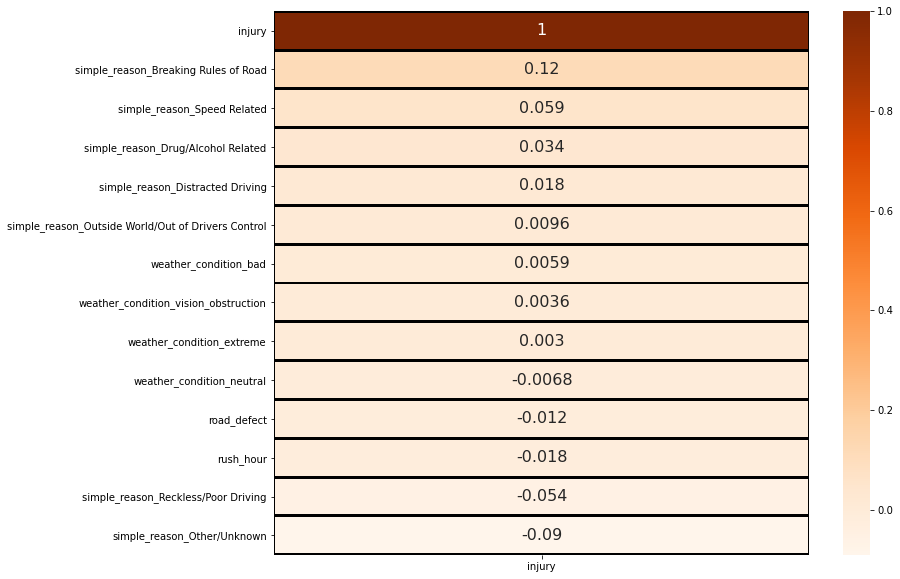

In [32]:
x = corr[['injury']]
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(x.sort_values(by=['injury'], ascending=0),
           annot=True,
           cmap='Oranges',
           annot_kws={'fontsize': 16},
           linewidth=2,
           linecolor='black',
           xticklabels = ['injury']);

In [33]:
X = new_df.drop(labels = ['injury', 'crash_date'], axis=1)
y = new_df['injury']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [35]:
# SMOTE that data!

# standardizing the data
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

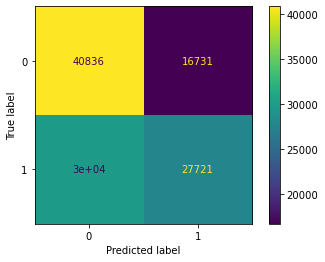

In [36]:
rand=RandomForestClassifier(random_state=42)
rand.fit(X_train, y_train)
plot_confusion_matrix(rand, X_test, y_test);

In [37]:
y_pred = rand.predict(X_test)

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

Accuracy: 0.5954539927388955
Precision: 0.6236164851975164
Recall: 0.4815432452620425
F1: 0.5434477891373175
AUC 0.5954539927388955
CVS 0.6361146141049956
